In [2]:
import pandas as pd
import matplotlib.pyplot as plt

naive_times = pd.DatetimeIndex(start='2017', end='2018', freq='1h')

# very approximate
# latitude, longitude, name, altitude, timezone
coordinates = [(30, -110, 'Tucson', 700, 'Etc/GMT+7'),
(30, 10, 'Ghadames', 330, 'Etc/GMT-2'),
(32, 15, 'Misurata', 10, 'Etc/GMT-2'),
(33, 13, 'Tripoli', 33, 'Etc/GMT-2'),
(43, 141, 'Sapporo', 10, 'Etc/GMT-9'),
(50, 10, 'Berlin', 34, 'Etc/GMT-1'),
(-24, 69, 'Atacama', 2400, 'Etc/GMT-1')]

import pvlib

# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']

# specify constant ambient air temp and wind for simplicity
temp_air = 20

wind_speed = 0

In [3]:
system = {'module': module, 'inverter': inverter,
           'surface_azimuth': 180}

In [83]:
energies = {}
ac_locs = {}
NCF = {}  #Net Capacity Factor: Divide sum of generation by the number of periods times the system size
# NCF_monthly=pd.DataFrame(columns=[list(range(len(coordinates)))])
NCF_monthly={}


for latitude, longitude, name, altitude, timezone in coordinates:
        times = naive_times.tz_localize(timezone)
        system['surface_tilt'] = latitude
        solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
        dni_extra = pvlib.irradiance.get_extra_radiation(times)
        airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
        pressure = pvlib.atmosphere.alt2pres(altitude)
        am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
        tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
        cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl,
                                     dni_extra=dni_extra, altitude=altitude)
        aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'],
                                   solpos['apparent_zenith'], solpos['azimuth'])
        total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'],
                                                            system['surface_azimuth'],
                                                            solpos['apparent_zenith'],
                                                            solpos['azimuth'],
                                                            cs['dni'], cs['ghi'], cs['dhi'],
                                                            dni_extra=dni_extra,
                                                            model='haydavies')
        temps = pvlib.pvsystem.sapm_celltemp(total_irrad['poa_global'],
                                             wind_speed, temp_air)
        effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
            total_irrad['poa_direct'], total_irrad['poa_diffuse'],
            am_abs, aoi, module)
        dc = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)
        ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)
        annual_energy = ac.sum()
        energies[name] = annual_energy
        interval=60
        system_capacity=220
        NCF[name]=annual_energy/(525600/int(interval) * system_capacity)
        ac_locs[name]=ac
        ac_mth_agg=ac.resample('M',how='sum')
        ncf_mon=ac_mth_agg/((740*60)/int(interval) * system_capacity)
        NCF_monthly[name]=pd.DataFrame(ncf_mon)


C:\Users\Mhdella\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


In [84]:
df_ac_locs=pd.DataFrame(ac_locs)
df_ac_locs
len(df_ac_locs.columns)
df_ac_magg=pd.DataFrame(ac_mth_agg)
# df_ac_magg
# ac_mth_agg
# len(df_ac_magg.columns)
# NCF_monthly

In [85]:
energies = pd.Series(energies)
NCF = pd.Series(NCF)
# based on the parameters specified above, these are in W*hrs
# print(energies.round(0))
decf = {'Energy':energies,'NCF':NCF}
df_E_NCF = pd.DataFrame(decf)
df_E_NCF

,Energy,NCF
Tucson,467728.320261,0.242698
Ghadames,462123.869640,0.239790
Misurata,462426.135667,0.239947
Tripoli,464865.169147,0.241213
Sapporo,476522.808287,0.247262
Berlin,383558.086966,0.199023
Atacama,540682.807904,0.280554


Text(0,0.5,'Yearly energy yield (W hr)')

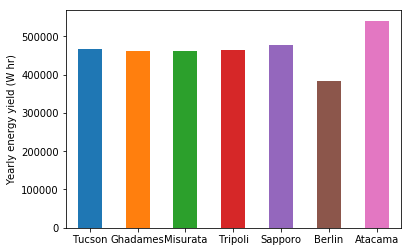

In [86]:
energies.plot(kind='bar', rot=0)

plt.ylabel('Yearly energy yield (W hr)')


In [79]:
energies.head()
ac.head()
# ac.describe()
annual_energy

540682.8079039201

In [80]:
system_capacity=220
max(ac)

207.3135185966198

In [ ]:
# print(ac_mth_agg) 

In [ ]:
ac_mth_agg/((740*60)/int(interval) * system_capacity)

In [88]:
NCF_monthly

{'Tucson':                                       0
 2017-01-31 00:00:00-07:00  2.257373e-01
 2017-02-28 00:00:00-07:00  2.230080e-01
 2017-03-31 00:00:00-07:00  2.613212e-01
 2017-04-30 00:00:00-07:00  2.528277e-01
 2017-05-31 00:00:00-07:00  2.530311e-01
 2017-06-30 00:00:00-07:00  2.366182e-01
 2017-07-31 00:00:00-07:00  2.443788e-01
 2017-08-31 00:00:00-07:00  2.500256e-01
 2017-09-30 00:00:00-07:00  2.456848e-01
 2017-10-31 00:00:00-07:00  2.458991e-01
 2017-11-30 00:00:00-07:00  2.208980e-01
 2017-12-31 00:00:00-07:00  2.135943e-01
 2018-01-31 00:00:00-07:00 -1.228501e-07,
 'Ghadames':                                       0
 2017-01-31 00:00:00+02:00  2.203661e-01
 2017-02-28 00:00:00+02:00  2.191983e-01
 2017-03-31 00:00:00+02:00  2.559561e-01
 2017-04-30 00:00:00+02:00  2.490863e-01
 2017-05-31 00:00:00+02:00  2.484260e-01
 2017-06-30 00:00:00+02:00  2.342217e-01
 2017-07-31 00:00:00+02:00  2.434961e-01
 2017-08-31 00:00:00+02:00  2.501236e-01
 2017-09-30 00:00:00+02:00  2.4484